# Определение перспективного тарифа для телеком компании

Анализ тарифов компании «Мегалайн» — федерального оператора сотовой связи. 
Цель данного анализа - на выборке из 500 клиентов, сравнить тарифы «Смарт» и «Ультра» и определить наиболее выгодный.

- [Предобработка данных](#join)
     - [Обзор](#overview)
     - [Работа с пустыми значениями](#preprocessing)
     - [Изменение типа данных](#types)
- [Расчет прибыли от клиентов](#columns)
- [Проверка гипотез](#hypothesis)
- [Заключение](#conclusion)
  

In [7]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats as st
from collections import defaultdict
import os

pd.options.display.float_format = '{:,.2f}'.format

sns.set()
warnings.filterwarnings('ignore')


%config InlineBackend.figure_format = 'retina'

In [8]:
cwd = os.getcwd()

In [9]:
calls = pd.read_csv(cwd + '/datasets/calls.csv', parse_dates=['call_date'])
internet = pd.read_csv(cwd + '/datasets/internet.csv', parse_dates=['session_date'], index_col=0)
tariffs = pd.read_csv(cwd + '/datasets/tariffs.csv')
messages = pd.read_csv(cwd + '/datasets/messages.csv', parse_dates=['message_date'])
users = pd.read_csv(cwd + '/datasets/users.csv', parse_dates=['churn_date', 'reg_date'])

## Предобработка данных <a id="join"></a>

### Обзор<a id="overview"></a>

In [10]:
datasets = {
    'calls': calls,
    'internet': internet,
    'tariffs': tariffs,
    'messages': messages,
    'users': users
}

In [11]:
for name, data in datasets.items():
    display(name, data.info())
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB


'calls'

None


<class 'pandas.core.frame.DataFrame'>
Int64Index: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            149396 non-null  object        
 1   mb_used       149396 non-null  float64       
 2   session_date  149396 non-null  datetime64[ns]
 3   user_id       149396 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 5.7+ MB


'internet'

None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


'tariffs'

None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB


'messages'

None


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  38 non-null     datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


'users'

None

In [12]:
for name, data in datasets.items():
    display(name, data.sample(2))
    print()

'calls'

,id,call_date,duration,user_id
111338,1285_266,2018-12-26,6.20,1285
194848,1477_596,2018-09-05,21.04,1477


'internet'

,id,mb_used,session_date,user_id
102810,1344_391,647.25,2018-04-04,1344
78311,1263_382,259.40,2018-10-29,1263


'tariffs'

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
1,1000,30720,3000,1950,150,1,1,ultra
0,50,15360,500,550,200,3,3,smart


'messages'

,id,message_date,user_id
74125,1313_42,2018-11-26,1313
22203,1093_85,2018-09-17,1093


'users'

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
396,1396,23,NaT,Пенза,Эльга,Савельева,2018-01-12,ultra
0,1000,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


In [13]:
def na_describe(name, df):
    na_df = pd.concat([df.isna().sum(), df.isna().sum()/len(df)*100], axis=1)
    na_df.columns = ["count", "% missing"]
    na_df = na_df[na_df["count"] > 0]
    na_df = na_df.sort_values(by="% missing", ascending=False)
    if na_df.empty:
        return f'{name} dataset has no missing values'
    return display(name, na_df)

In [14]:
for name, dataset in datasets.items():
    display(na_describe(name, dataset))

'calls dataset has no missing values'

'internet dataset has no missing values'

'tariffs dataset has no missing values'

'messages dataset has no missing values'

'users'

,count,% missing
churn_date,462,92.40


None

Пустые значения есть только в столбце который содержит данные об ушедших клиентах. Он поможет нам посчитать выручку от каждого клиента, пустые значения пока оставим 

### Предобработка

Начнем с подсчета ежемесячного потребления для каждого клиента

Для начала округлим продолжительность звонков как это бы сделал оператор

In [15]:
calls['duration'] = calls['duration'].apply(np.ceil)

In [16]:
calls.sample(2)

,id,call_date,duration,user_id
118786,1307_260,2018-12-10,9.00,1307
30057,1076_349,2018-11-26,0.00,1076


В каждую таблицу добавим столбец с месяцем 

In [17]:
for data in datasets.values():
    for column_name in data.columns:
        if column_name not in ['churn_date', 'reg_date']:
            if 'date' in column_name:
                data['month'] = data[column_name].dt.month

Теперь мы можем подсчитать потребление каждого клиента за каждый месяц. Начнем с таблицы 'calls'

In [18]:
calls_month = calls.groupby(['user_id', 'month'])['duration'].agg(['sum', 'count'])
calls_month.columns = ['month_minutes', 'month_calls']
calls_month.sample()

,,month_minutes,month_calls
user_id,month,,
1392,3,467.00,60


In [19]:
calls[calls['duration'] == 0].count()

id           39613
call_date    39613
duration     39613
user_id      39613
month        39613
dtype: int64

In [20]:
calls[calls['duration'] > 0].shape

(162994, 5)

У нас много звонков с продолжительностью = 0 минут.
Это не ошибки а пропущенные звонки на которых небыло потрачено минут из тарифа. Не будем их удалять так как они никак не помешают нашему анализу

Проделаем тоже самое для таблиц 'internet' и 'messages'

In [21]:
messages_month = messages.groupby(['user_id', 'month'])['id'].agg(['count'])
messages_month.columns = ['month_messages']
messages_month.sample(5)

,,month_messages
user_id,month,
1002,9,4
1396,9,74
1158,7,69
1433,3,86
1264,12,16


In [22]:
internet[internet['mb_used'] == 0].shape

(19598, 5)

Интернет сессии не затратившие ни одного мб могут быть просто не открытыми уведомлениями от разных аппликаций как инстаграм, телеграм итд. Предположительно  используется только маленькая фракция одного мегабайта и по этой причине записывается 0. Другой вариант это то что пользователи были подключены к сети Wifi. В любом случае эти записи можно удалить так как они ничем не помогут нашему анализу и их удаление никак на него не повлияет

In [23]:
internet = internet[internet['mb_used'] > 0]

In [24]:
internet_month = internet.groupby(['user_id', 'month'])['mb_used'].agg(['sum'])
internet_month.columns = ['month_traffic']
internet_month.sample(5)

,,month_traffic
user_id,month,
1440,5,"3,370.69"
1180,10,"43,574.62"
1078,8,"22,508.96"
1030,7,"13,118.31"
1109,5,"11,958.34"


Для того чтобы было удобней дальше проводить анализ и совершать нужные посчеты, обьеденим талблицы 'calls_month', 'messages_month' и 'internet_month' с таблицей 'users

In [25]:
month_data = pd.concat([calls_month, internet_month, messages_month], axis=1).reset_index()
month_data.sample(5)

,user_id,month,month_minutes,month_calls,month_traffic,month_messages
299,1048,12,688.00,97.00,"8,177.23",78.00
1173,1183,8,579.00,69.00,"21,020.16",41.00
2724,1424,11,16.00,6.00,"17,145.74",83.00
1093,1173,6,307.00,42.00,"11,687.01",3.00
2336,1372,3,473.00,64.00,"13,232.94",32.00


Теперь нам нужнo округлить потребление трафика как это делает Мегалайн

In [26]:
mb_in_gb = 1000 

def round_to_next_thousand(number):
    if number == 0:
        return 0
    new_value = round(number, -3)
    if new_value > number:
        return new_value
    return new_value + mb_in_gb

In [27]:
month_data['month_traffic'] = month_data['month_traffic'].apply(round_to_next_thousand)

In [28]:
df = users.merge(month_data, on='user_id', how='outer')

## 3. Предобработка - пустые значения <a id="preprocessing"></a>



In [29]:
df[df['month_calls'].isna()].sample(3)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,month_minutes,month_calls,month_traffic,month_messages
3151,1489,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,8.00,nan,nan,"12,000.00",17.00
676,1106,67,NaT,Калуга,Исаак,Костин,2018-04-26,ultra,9.00,nan,nan,"22,000.00",23.00
827,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,nan,nan,nan,nan,nan


In [30]:
df[df['month_messages'].isna()].sample(3)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,month_minutes,month_calls,month_traffic,month_messages
393,1063,45,2018-12-11,Тула,Таира,Климова,2018-04-12,ultra,5.00,716.00,120.00,"22,000.00",nan
1183,1185,26,NaT,Санкт-Петербург,Мануэла,Родина,2018-04-13,ultra,4.00,617.00,80.00,"31,000.00",nan
2994,1466,37,NaT,Новосибирск,Рубен,Шевцов,2018-02-28,ultra,5.00,492.00,73.00,"15,000.00",nan


In [31]:
df[df['month_traffic'].isna()].sample(3)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,month_minutes,month_calls,month_traffic,month_messages
1723,1273,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,5.00,220.00,24.00,nan,21.00
2389,1377,59,NaT,Брянск,Альфред,Семин,2018-02-25,ultra,2.00,179.00,23.00,nan,2.00
1729,1273,46,NaT,Курган,Рэм,Корнилов,2018-05-15,ultra,11.00,272.00,45.00,nan,29.00


У нас есть пустые значения но это может значить что клиент не использовал данную услугу в течение месяца, но использовал другие. У многих клиентов которые звонили и использовалии интернет, пустые значения в столбце отправленных сообщений. Выглядит правдоподобно так как если есть интернет зачем отправлять смс? Заменим пустые значения на 0

In [32]:
columns = ['month_minutes', 'month_calls', 'month_traffic', 'month_messages']
df[columns] = df[columns].fillna(0)

In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3216 non-null   int64         
 1   age             3216 non-null   int64         
 2   churn_date      189 non-null    datetime64[ns]
 3   city            3216 non-null   object        
 4   first_name      3216 non-null   object        
 5   last_name       3216 non-null   object        
 6   reg_date        3216 non-null   datetime64[ns]
 7   tariff          3216 non-null   object        
 8   month           3214 non-null   float64       
 9   month_minutes   3216 non-null   float64       
 10  month_calls     3216 non-null   float64       
 11  month_traffic   3216 non-null   float64       
 12  month_messages  3216 non-null   float64       
dtypes: datetime64[ns](2), float64(5), int64(2), object(4)
memory usage: 351.8+ KB


In [34]:
df[df['month'].isna()]

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,month_minutes,month_calls,month_traffic,month_messages
827,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,nan,0.00,0.00,0.00,0.00
2335,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart,nan,0.00,0.00,0.00,0.00


Мы видим что у нас есть два клиента у которых пустуют столбцы с основными данными. По датам видно что это люди отменили свой пакет пару дней после дня регистрации. Можно просто их удалить из таблицы

In [35]:
df = df.drop(df.index[[827, 2335]])

In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3215
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3214 non-null   int64         
 1   age             3214 non-null   int64         
 2   churn_date      187 non-null    datetime64[ns]
 3   city            3214 non-null   object        
 4   first_name      3214 non-null   object        
 5   last_name       3214 non-null   object        
 6   reg_date        3214 non-null   datetime64[ns]
 7   tariff          3214 non-null   object        
 8   month           3214 non-null   float64       
 9   month_minutes   3214 non-null   float64       
 10  month_calls     3214 non-null   float64       
 11  month_traffic   3214 non-null   float64       
 12  month_messages  3214 non-null   float64       
dtypes: datetime64[ns](2), float64(5), int64(2), object(4)
memory usage: 351.5+ KB


Посчитаем ежемесячный доход от каждого клиента

Для тех кто аннулировал контракт с оператором, считать будем только до даты ухода. Чтобы было удобней делать подсчеты, заменим пустые значения в столбце 'churn_date' на последнюю дату 2018 года так как выручку мы подсчитываем помесячно за 1 год

In [37]:
df.sample()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,month,month_minutes,month_calls,month_traffic,month_messages
2386,1376,46,NaT,Самара,Пётр,Акимов,2018-05-31,smart,10.00,490.00,60.00,"22,000.00",0.00


## Изменение типа данных <a id="types"></a>


На данном этапе - оптимизируем хранение данных. Изменим тип данных так чтобы датасет занимал как можно меньше памяти

In [38]:
int_df = df.select_dtypes(include=['int'])
converted_int = int_df.apply(pd.to_numeric, downcast='unsigned')
df[converted_int.columns] = converted_int

In [39]:
float_df = df.select_dtypes(include=['float'])
converted_float = float_df.apply(pd.to_numeric, downcast='unsigned')
df[converted_float.columns] = converted_float

Теперь обработаем данные типа 'object'. Их можно хранить в памяти как простое число 'int' но для этого стоит сначала проверить не превышает ли число уникальных значений половину из всех обьектов - в таком случае выгоднее хранить данные типа 'object'

In [40]:
df_obj = df.select_dtypes(include=['object'])
df_obj.describe()

,city,first_name,last_name,tariff
count,3214,3214,3214,3214
unique,76,246,417,2
top,Москва,Мариетта,Андреенко,smart
freq,611,39,35,2229


In [41]:
converted_obj = pd.DataFrame()

for col in df_obj.columns:
    num_unique_values = len(df_obj[col].unique())
    num_total_values = len(df_obj[col])
    if num_unique_values / num_total_values < 0.5:
        converted_obj.loc[:,col] = df_obj[col].astype('category')
    else:
        converted_obj.loc[:,col] = df_obj[col]


In [42]:
df[converted_obj.columns] = converted_obj
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3215
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         3214 non-null   uint16        
 1   age             3214 non-null   uint8         
 2   churn_date      187 non-null    datetime64[ns]
 3   city            3214 non-null   category      
 4   first_name      3214 non-null   category      
 5   last_name       3214 non-null   category      
 6   reg_date        3214 non-null   datetime64[ns]
 7   tariff          3214 non-null   category      
 8   month           3214 non-null   uint8         
 9   month_minutes   3214 non-null   uint16        
 10  month_calls     3214 non-null   uint8         
 11  month_traffic   3214 non-null   uint16        
 12  month_messages  3214 non-null   uint8         
dtypes: category(4), datetime64[ns](2), uint16(3), uint8(4)
memory usage: 163.9 KB


## Расчет прибыли от клиентов<a id="columns"></a>


Дополним нашу талбицу информацией о каждом пакете чтобы было легче считать прибыль

In [43]:
tariffs = tariffs.T

In [44]:
tariffs = tariffs.rename(columns={0: 'smart', 1: 'ultra'})
tariffs.drop('tariff_name', axis=0, inplace=True)

In [45]:
tariffs

,smart,ultra
messages_included,50,1000
mb_per_month_included,15360,30720
minutes_included,500,3000
rub_monthly_fee,550,1950
rub_per_gb,200,150
rub_per_message,3,1
rub_per_minute,3,1


In [46]:
for index, row in tariffs.iterrows():
    for i in range(2):
        df.loc[df['tariff'] == tariffs.columns[i], index] = row[i]

In [47]:
def profit_calc(row):
    message_profit = (row['month_messages'] - row['messages_included']) * row['rub_per_message']
    if message_profit < 0:
        message_profit =0
    call_profit = (row['month_minutes'] - row['minutes_included']) * row['rub_per_minute']
    if call_profit < 0:
        call_profit =0
    internet_profit = ((row['month_traffic'] - row['mb_per_month_included']) / mb_in_gb) * row['rub_per_gb']
    if internet_profit < 0:
        internet_profit = 0
    return message_profit + call_profit + internet_profit + row['rub_monthly_fee']

In [48]:
df['profit_by_month'] = df.apply(profit_calc, axis=1)

In [49]:
total_profit = df.groupby('user_id')['profit_by_month'].agg(['sum']).reset_index()
total_profit.sample(5)

,user_id,sum
490,1492,"12,990.00"
49,1049,"19,500.00"
145,1146,"10,390.00"
180,1181,"3,924.00"
492,1494,"4,865.00"


In [50]:
total_profit_dict = {
    row['user_id']: row['sum'] for index, row in total_profit.iterrows()
}

df['total_profit'] = df['user_id'].map(total_profit_dict)

Изменим снова тип чтоб таблице меньше весила

In [51]:
float_df = df.select_dtypes(include=['float'])
converted_float = float_df.apply(pd.to_numeric, downcast='unsigned')
df[converted_float.columns] = converted_float

In [52]:
df.duplicated().sum()

0

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3215
Data columns (total 22 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   user_id                3214 non-null   uint16        
 1   age                    3214 non-null   uint8         
 2   churn_date             187 non-null    datetime64[ns]
 3   city                   3214 non-null   category      
 4   first_name             3214 non-null   category      
 5   last_name              3214 non-null   category      
 6   reg_date               3214 non-null   datetime64[ns]
 7   tariff                 3214 non-null   category      
 8   month                  3214 non-null   uint8         
 9   month_minutes          3214 non-null   uint16        
 10  month_calls            3214 non-null   uint8         
 11  month_traffic          3214 non-null   uint16        
 12  month_messages         3214 non-null   uint8         
 13  mes

Удалим из таблицы столбцы которые нам не понадобятся в дальнейшем

In [54]:
df.drop([
    'messages_included',
    'mb_per_month_included',
    'minutes_included',
    'rub_monthly_fee',
    'rub_per_gb',
    'rub_per_message',
    'rub_per_minute',
    'first_name', 
    'last_name'
],
    axis=1
)

,user_id,age,churn_date,city,reg_date,tariff,month,month_minutes,month_calls,month_traffic,month_messages,profit_by_month,total_profit
0,1000,52,NaT,Краснодар,2018-05-25,ultra,5,159,22,3000,22,1950,15600
1,1000,52,NaT,Краснодар,2018-05-25,ultra,6,172,43,24000,60,1950,15600
2,1000,52,NaT,Краснодар,2018-05-25,ultra,7,340,47,15000,75,1950,15600
3,1000,52,NaT,Краснодар,2018-05-25,ultra,8,408,52,15000,81,1950,15600
4,1000,52,NaT,Краснодар,2018-05-25,ultra,9,466,58,15000,57,1950,15600
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1498,68,2018-10-25,Владикавказ,2018-07-19,smart,10,247,41,21000,42,1678,6820
3212,1499,35,NaT,Пермь,2018-09-27,smart,9,70,9,2000,11,550,3667
3213,1499,35,NaT,Пермь,2018-09-27,smart,10,449,68,18000,48,1078,3667
3214,1499,35,NaT,Пермь,2018-09-27,smart,11,612,74,18000,59,1441,3667


In [88]:
s = (df.dtypes == 'category')
category_columns = list(s[s].index)
category_columns

['city', 'first_name', 'last_name', 'tariff']

In [92]:
s[s].index

Index(['city', 'first_name', 'last_name', 'tariff'], dtype='object')

## Анализ данных <a id="analysis"></a>

Ответим на главный вопрос исследования - какой тариф выгодней для компании?

In [55]:
df.groupby('tariff').agg({'profit_by_month': 'mean', 'total_profit': 'mean'})

,profit_by_month,total_profit
tariff,,
smart,"1,302.45","10,428.72"
ultra,"2,073.11","17,017.31"


Пользователи 'ultra' приносят в среднем больше дохода чем поьзователи 'smart'. Проанализируем ситуацию

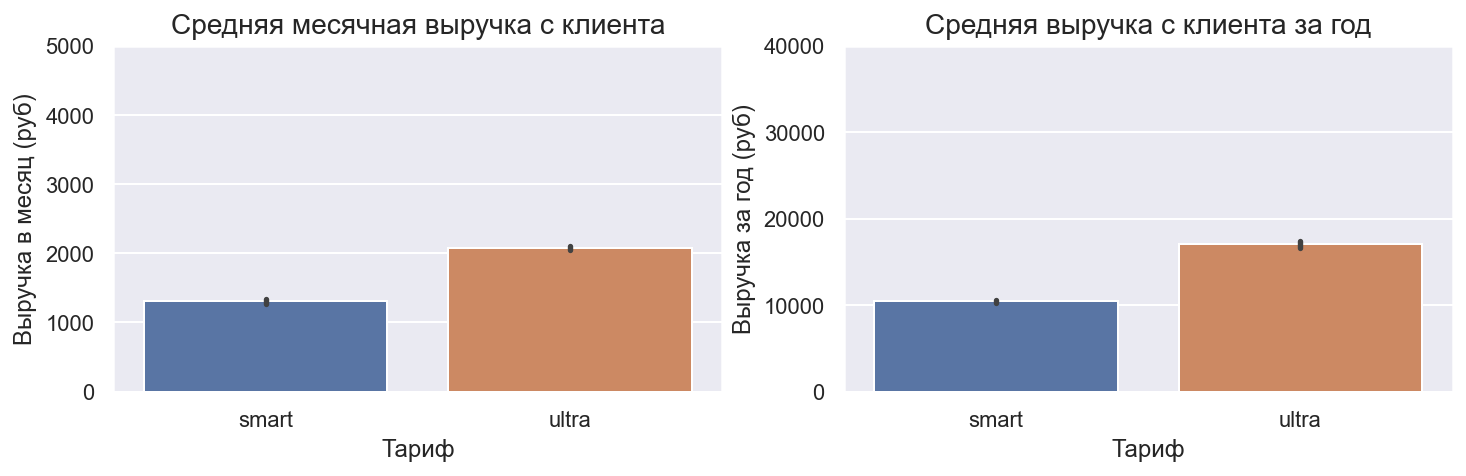

In [56]:
plt.figure(figsize=(12,7))
plt.subplot(2,2,2)
plt.xlim([0, 3])
plt.ylim([0, 40000])
plt.title('Средняя выручка с клиента за год', size=14)
sns.barplot(df['tariff'], df['total_profit']);
plt.ylabel('Выручка за год (руб)')
plt.xlabel('Тариф')


plt.subplot(2, 2, 1)
plt.xlim([0, 3])
plt.ylim([0, 5000])
plt.title('Средняя месячная выручка с клиента', size=14)

sns.barplot(df['tariff'], df['profit_by_month']);
plt.ylabel('Выручка в месяц (руб)')
plt.xlabel('Тариф');



На это простом столбчатом графике видно что в среднем прибыли компания получает больше от пользователей с тарифом 'ultra'. Исследуем так же количество звонков, сообщений и обьем интернет трафика для обоих тарифов

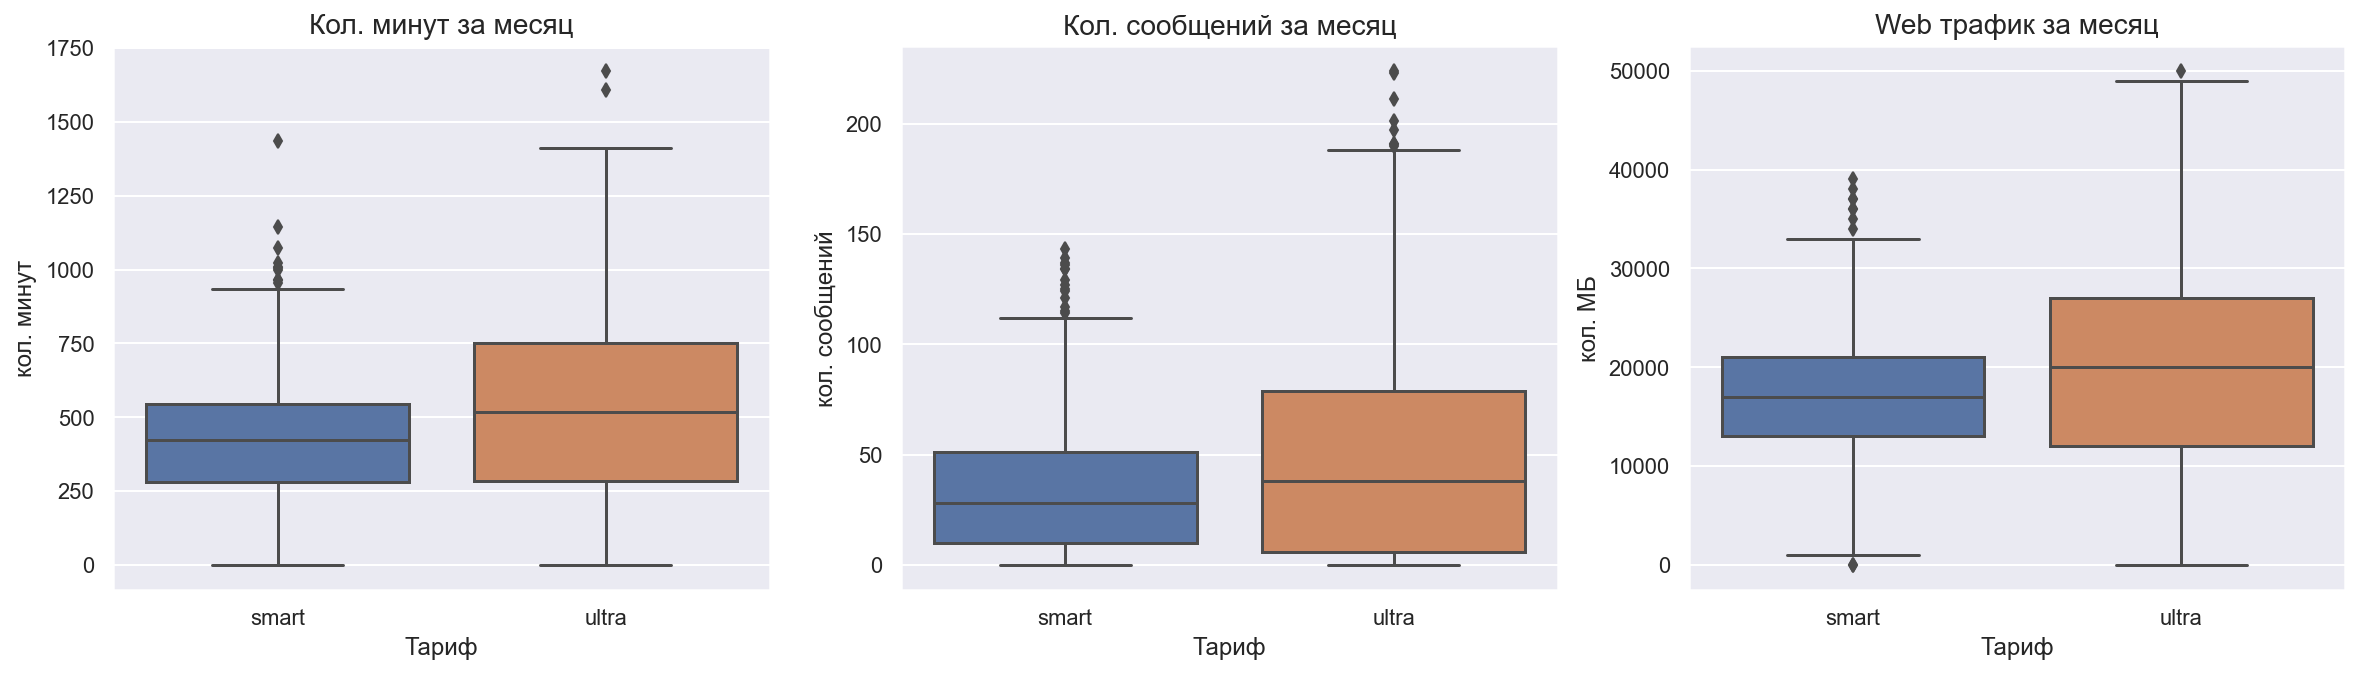

In [57]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

axes[0].set_title("Кол. минут за месяц", size=14);
sns.boxplot('tariff', 'month_minutes', ax=axes[0], data=df);
axes[0].set(xlabel='Тариф', ylabel='кол. минут');

axes[1].set_title("Кол. сообщений за месяц", size=14);
sns.boxplot(x='tariff', y='month_messages', ax=axes[1], data=df);
axes[1].set(xlabel='Тариф', ylabel='кол. сообщений');

axes[2].set_title("Web трафик за месяц", size=14);
sns.boxplot(x='tariff', y='month_traffic',ax=axes[2], data=df);
axes[2].set(xlabel='Тариф', ylabel='кол. МБ');


Больше минут, сообщений и мегабайтов потребляют пользователи с тарифом 'ultra' но это логично так как в него изначально входит большее их количества. Вопрос в том - у которого из пакетов потребление пользователей чаще превышает первычный лимит 

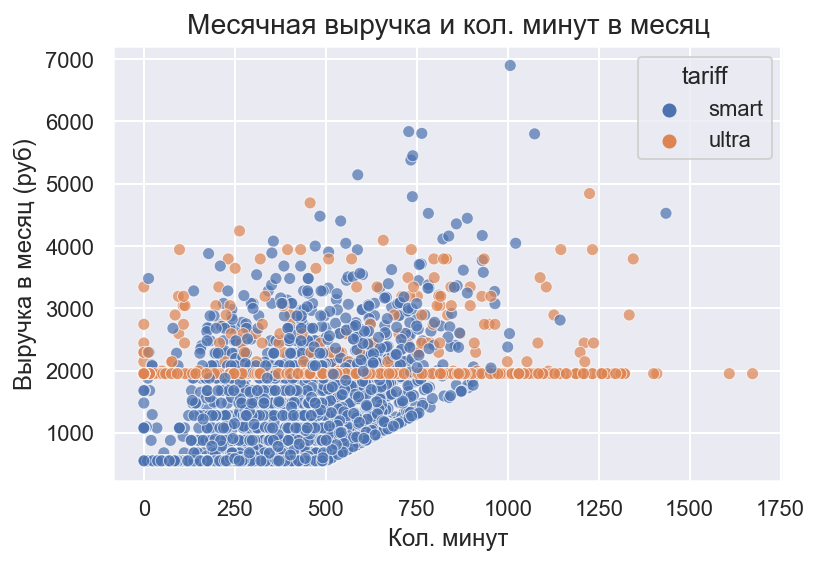

In [58]:
sns.scatterplot(df['month_minutes'], df['profit_by_month'], hue=df['tariff'], alpha=0.7);
plt.title('Месячная выручка и кол. минут в месяц', size=14);
plt.xlabel('Кол. минут');
plt.ylabel('Выручка в месяц (руб)');

На графике видно что клиентов с тарифом 'smart' которые превысили месячный лимит гораздо больше чем людей с пакетом 'ultra' вышедших за рамки 

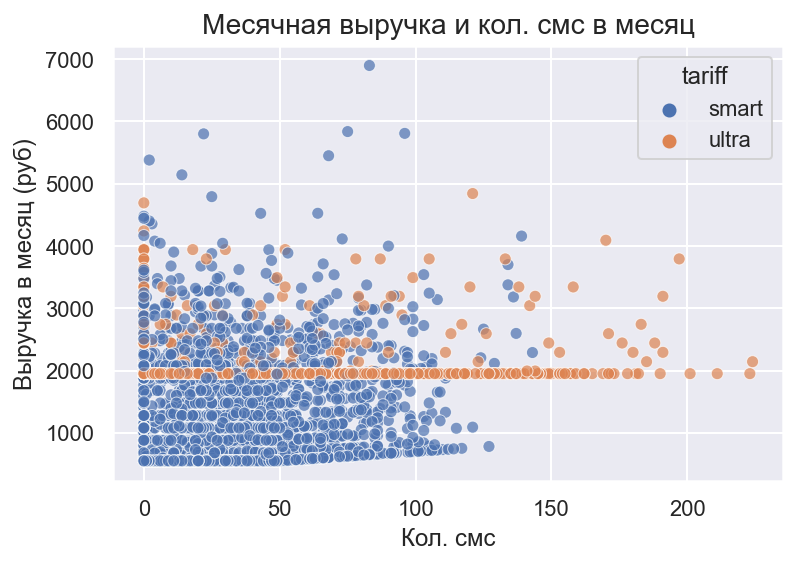

In [59]:
sns.scatterplot(df['month_messages'], df['profit_by_month'], hue=df['tariff'],  alpha=0.7);
plt.title('Месячная выручка и кол. смс в месяц', size=14);
plt.xlabel('Кол. смс');
plt.ylabel('Выручка в месяц (руб)');


Данный график так же указывает на то что пользователи с пакетом ultra реже выходят за грани предоставленых пакетом смс и выручка от этих  пользователей равняется стабильной цене тарифа

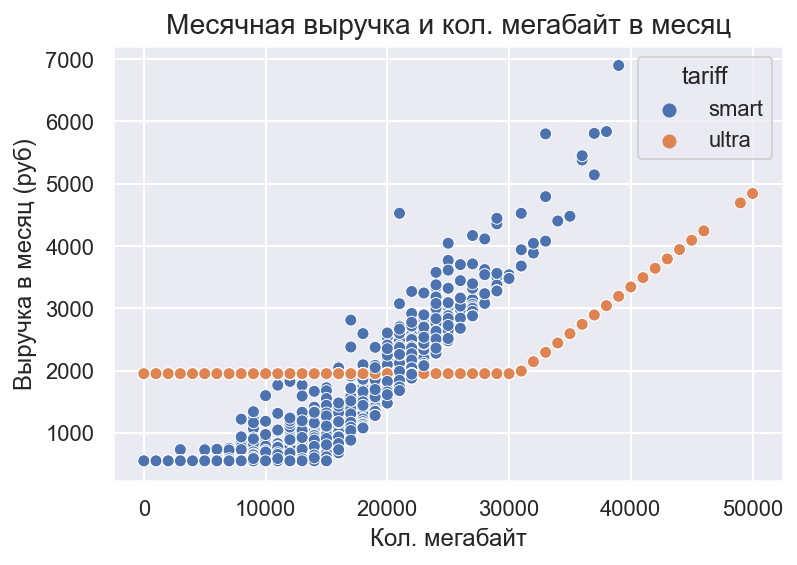

In [60]:
sns.scatterplot(df['month_traffic'], df['profit_by_month'], hue=df['tariff']);
plt.title('Месячная выручка и кол. мегабайт в месяц', size=14);
plt.xlabel('Кол. мегабайт');
plt.ylabel('Выручка в месяц (руб)');


Опять на графике видно что пользователи тарифа 'smart' тратят больше чем изначально включено в тариф

In [61]:
df_smart = df[df['tariff'] == 'smart']
df_ultra = df[df['tariff'] == 'ultra']

In [62]:
def overdue_calc(df):
    overduers_mb = df[df['month_traffic'] > df['mb_per_month_included']]
    overduers_min = df[df['month_calls'] > df['minutes_included']]
    overduers_sms = df[df['month_messages'] > df['messages_included']]
    
    percentage_of_overduers_mb = len(overduers_mb.groupby('user_id')) / len(df.groupby('user_id'))
    percentage_of_overduers_min = len(overduers_min.groupby('user_id')) / len(df.groupby('user_id'))
    percentage_of_overduers_sms = len(overduers_sms.groupby('user_id')) / len(df.groupby('user_id'))
    
    print(f'Процент людей с тарифом smart потративших больше мб чем включены в тариф {percentage_of_overduers_mb:.2%}')
    print(f'Процент людей с тарифом smart потративших больше минут чем включены в тариф {percentage_of_overduers_min:.2%}')
    print(f'Процент людей с тарифом smart потративших больше смс чем включены в тариф {percentage_of_overduers_sms:.2%}')

In [63]:
overdue_calc(df_smart)

Процент людей с тарифом smart потративших больше мб чем включены в тариф 89.71%
Процент людей с тарифом smart потративших больше минут чем включены в тариф 0.00%
Процент людей с тарифом smart потративших больше смс чем включены в тариф 35.71%


In [64]:
overdue_calc(df_ultra)

Процент людей с тарифом smart потративших больше мб чем включены в тариф 31.08%
Процент людей с тарифом smart потративших больше минут чем включены в тариф 0.00%
Процент людей с тарифом smart потративших больше смс чем включены в тариф 0.00%


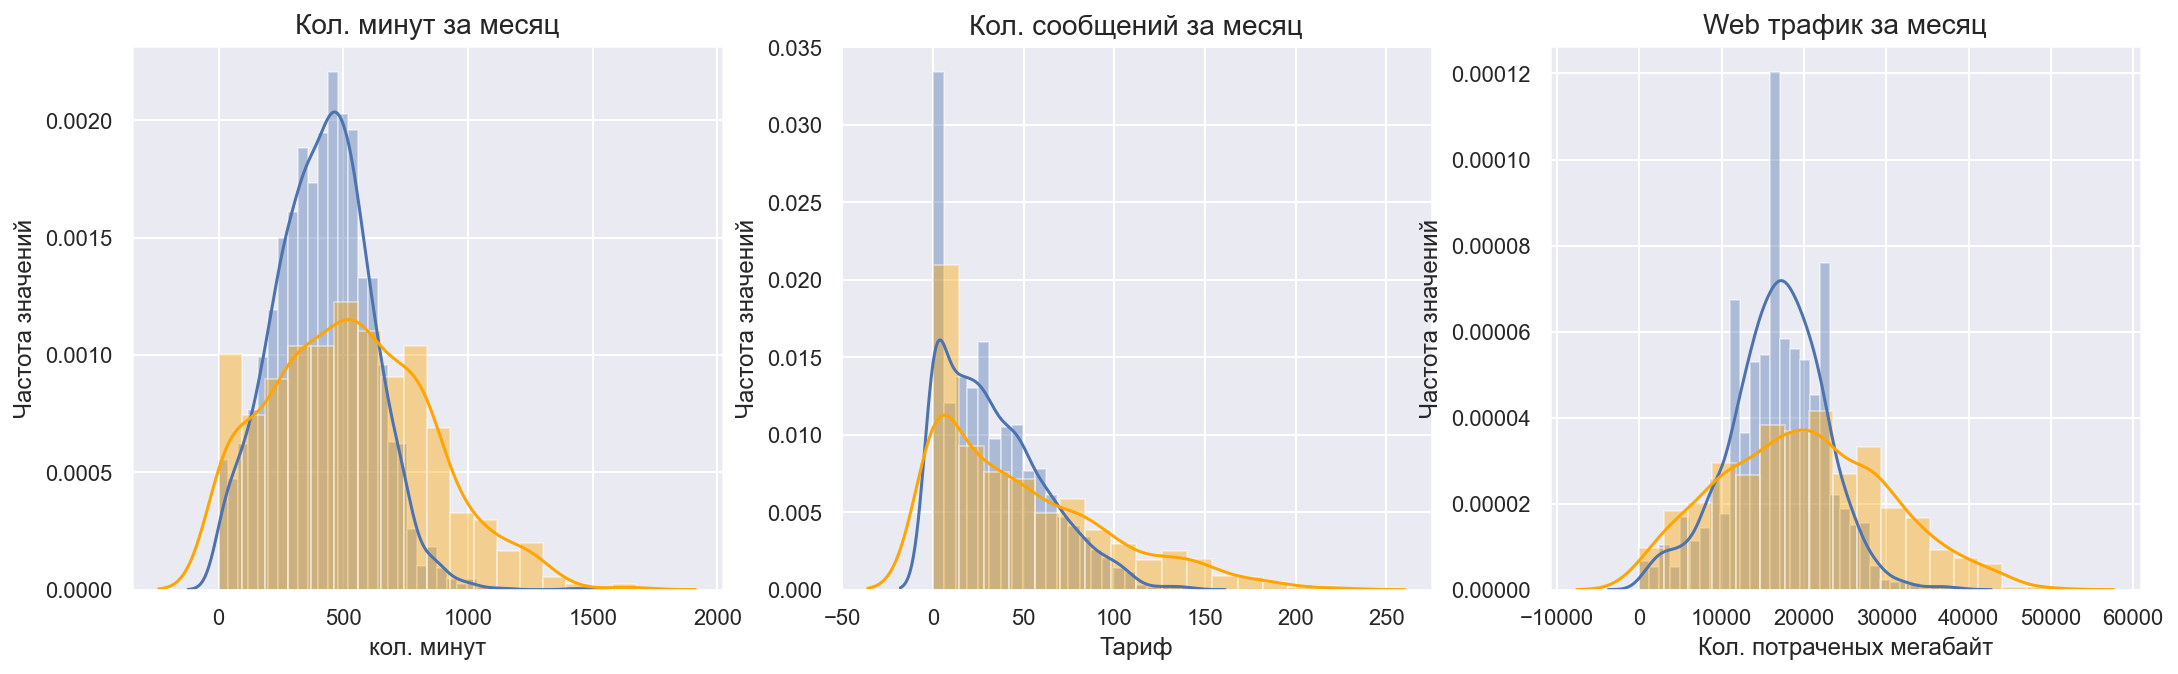

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

axes[0].set_title("Кол. минут за месяц", size=14);
sns.distplot(df_smart['month_minutes'], ax=axes[0]);
sns.distplot(df_ultra['month_minutes'], ax=axes[0], color='orange');
axes[0].set(xlabel='кол. минут', ylabel='Частота значений');

axes[1].set_title("Кол. сообщений за месяц", size=14);
sns.distplot(df_smart['month_messages'], ax=axes[1]);
sns.distplot(df_ultra['month_messages'], ax=axes[1], color='orange');
axes[1].set(xlabel='Тариф', ylabel='Частота значений');

axes[2].set_title("Web трафик за месяц", size=14);
sns.distplot(df_smart['month_traffic'], ax=axes[2]);
sns.distplot(df_ultra['month_traffic'], ax=axes[2], color='orange');
axes[2].set(xlabel='Кол. потраченых мегабайт', ylabel='Частота значений');

Как нам уже показал ящик с усами - клиенты с тарифом 'ultra' звонят больше и соответственно тратят больше минут.

Тоже самоей можно сказать о количестве высланных сообщений и о потраченых мб в интернете.

Большое число клиентов не отправляют СМС - скорее всего соц. сети заменили этот функционал.

Распределение cтремится к нормальному на графиках количества минут и трафика, за исключением выбросов и того факта что у нас выборка относительно небольшая для того чтобы данные полностью приобрели форму нормального расспределения. 

На гистограмме с трафиком большой пик указывает на то что большое число пользователей с тарифом смарт тратят примерно 16-17 гб в месяц. В тариф смарт включены 16 гб и мы посчитали что почти все пользователи 'smart' превышают этот рубеж. Посмотрим на сколько

In [66]:
smart_internet_overduers = df_smart[df_smart['month_traffic'] > df_smart['mb_per_month_included']]
smart_internet_overduers['month_traffic'].describe()

count    1,347.00
mean    20,409.06
std      3,635.27
min     16,000.00
25%     18,000.00
50%     20,000.00
75%     22,000.00
max     39,000.00
Name: month_traffic, dtype: float64

In [67]:
feature_col = [
    'month_minutes',
    'month_traffic',
    'month_messages',
    'profit_by_month',
    'total_profit',
    'tariff'
]

In [68]:
metrics = df[feature_col].groupby('tariff').agg(['mean', 'var', 'std'])

metrics.T

tariff                       smart          ultra
month_minutes   mean        417.93         526.62
                var      36,219.32     100,873.63
                std         190.31         317.61
month_traffic   mean     16,695.83      19,965.48
                var  34,543,882.94 102,029,295.12
                std       5,877.40      10,100.96
month_messages  mean         33.38          49.36
                var         796.81       2,285.27
                std          28.23          47.80
profit_by_month mean      1,302.45       2,073.11
                var     692,759.27     146,903.85
                std         832.32         383.28
total_profit    mean     10,428.72      17,017.31
                var  29,659,191.11  35,376,412.91
                std       5,446.03       5,947.81

In [69]:
df.groupby('tariff')['total_profit'].agg(['sum', 'count'])

,sum,count
tariff,,
smart,"23,245,622.00",2229
ultra,"16,762,050.00",985


Тариф 'ultra' приносит больше выручки с клиента в среднем чем 'smart' но больше клиентов предпочитают второй вариант (наверное потому что он дешевле) даже если это часто их заставляет докупать интернет трафик.

## Проверка гипотез <a id="hypothesis"></a>

Проверим гипотезу о равенстве средней выручки пользователей тарифов 'ultra' и 'smart'

H0: средняя выручка пользователей ultra равна средней выручки пользователей smart

H1: иначе

In [70]:
smart_col = df_smart['total_profit'] 
ultra_col = df_ultra['total_profit'] 
test_result = st.ttest_ind(smart_col, ultra_col, equal_var = False)
alpha = 0.01
if test_result.pvalue < alpha:
    print(f'pvalue={test_result.pvalue}')
    print('Средняя выручка пользователей "ultra" и "smart" не равна при 1% уровне значимости, нулевая гипотеза отвергается')
else:
    print(f'pvalue={test_result.pvalue}')
    print('Средняя выручки пользователей "ultra" и "smart" равна при 1% уровне значимости, не удалось отвергнуть нулевую гипотезу')

pvalue=3.5884905428123006e-157
Средняя выручка пользователей "ultra" и "smart" не равна при 1% уровне значимости, нулевая гипотеза отвергается


Проверим гипотезу о равенстве средней выручки клиентов из Москвы и клиентов из других регионов
H0: средняя выручка пользователей из Москвы равна средней выручки пользователей из других регионов
H1: иначе

Для выборок размером 100-1000 подходит уровень значимости 0.01. Чем меньше выборка тем больше вероятности получить ошибку тоесть тем большее значение значимости нам нужно.

Посчитаем дисперсию 

In [71]:
moscow_profit = df[df['city'] == 'Москва']['total_profit']
other_profit = df[df['city'] != 'Москва']['total_profit']

moscow_var = np.var(moscow_profit)
other_var = np.var(other_profit)
                   
print(f'Для московских пользователей дисперсия выручки равна {moscow_var}')
print(f'Для пользователей других регионов дисперсия выручки равна {other_var}')
                   

Для московских пользователей дисперсия выручки равна 44055292.031934984
Для пользователей других регионов дисперсия выручки равна 39810350.71496952


In [72]:
test_result = st.ttest_ind(moscow_profit, other_profit, equal_var = False)
alpha = 0.01
if test_result.pvalue < alpha:
    print(f'pvalue={test_result.pvalue}')
    print('Средняя выручка пользователей из Москвы и из других регионов не равна при 1% уровне значимости, нулевая гипотеза отвергается.')
else:
    print(f'pvalue={test_result.pvalue}')
    print('Средняя выручка пользователей из Москвы и из других регионов равна при 1% уровне значимости, не удалось отвергнуть нулевую гипотезу.')

pvalue=0.87560918657611
Средняя выручка пользователей из Москвы и из других регионов равна при 1% уровне значимости, не удалось отвергнуть нулевую гипотезу.


## Общий вывод <a id="conclusion"></a>

- Tables are processed, the data is transformed to required types, new columns were added to simplify calculations

- Hypotheses test are done: the revenue of smart and ultra tariffs differs, the revenue of customers from Moscow and other regions do not differ - with a 1% level of significance.

- Smart users use less calls, SMS and traffic, but 90% of them buy additional megabytes.


- 'Ultra' is more profitable for Megalain but it is used by fewer people and in order to increase its profit the company should lower its prices and also provide less traffic per month. Mostly people have 20 GB per month. Smart tariff is more popular because it is cheaper and the total revenue from it is more than from Ultra but people often buy GB and according to the data. It is clear that <code> the optimal tariff for customers would include more than 16 GB and cost less than Ultra tariff. </code> Megalain could, for example, create an 'optimum' tariff that would cost 1000 rubles per month and include 20 GB 